In [38]:
# clone the repository
git clone https://github.com/dsikar/fire-light.git

--2020-11-03 17:46:33--  http://www.sikarsystems.com/fire_data.tar.gz
Resolving www.sikarsystems.com (www.sikarsystems.com)... 66.147.244.173
Connecting to www.sikarsystems.com (www.sikarsystems.com)|66.147.244.173|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘fire_data.tar.gz’

fire_data.tar.gz        [ <=>                ]       0  --.-KB/s    in 0s      

2020-11-03 17:46:35 (0.00 B/s) - ‘fire_data.tar.gz’ saved [0]



In [54]:
# get the data
# Install PyDrive
!pip install PyDrive

#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the Shareable link
#Ex link : https://drive.google.com/file/d/1c7Ffo1Go1dtUpKcSWxdbdVyW4dfhEoUp/view?usp=sharing
# Get the id from the link 1JYdxKasFKNfVqx2Iklj7iv_bwPanmi4j
downloaded = drive.CreateFile({'id':"1JYdxKasFKNfVqx2Iklj7iv_bwPanmi4j"})   
# Remember at least what was the file extension
downloaded.GetContentFile('fire_data.tar.gz')       

In [ ]:
# unpack
!tar xvf fire_data.tar.gz

In [61]:
!mv Codes/datasets/tmp/* fire-light/Codes/datasets/

In [62]:
import os
import cv2
import numpy as np
from tqdm import tqdm

In [63]:
DATADIR = 'fire-light/Codes/datasets/'
CATEGORIES = ['fire', 'nofire']

In [64]:
IMG_SIZE = 64
def create_training_data():
    training_data = []
    for category in CATEGORIES:  

        path = os.path.join(DATADIR,category) 
        class_num = CATEGORIES.index(category)  # get the classification  (0 or a 1). 0=C 1=O

        for img in tqdm(os.listdir(path)):  # iterate over each image
            try:
                img_array = cv2.imread(os.path.join(path,img))  # convert to array
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize to normalize data size
                training_data.append([new_array, class_num])  # add this to our training_data
            except Exception as e:  # in the interest in keeping the output clean...
                pass
              
    return training_data

In [65]:
training_data = create_training_data()

100%|██████████| 95/95 [00:11<00:00,  8.17it/s]


In [66]:
import random

print(len(training_data))
random.shuffle(training_data)
for sample in training_data[:10]:
    print(sample[1])

270
0
0
1
0
0
0
0
0
1
0


In [68]:
X = []
Y = []

for features,label in training_data:
    X.append(features)
    Y.append(label)

# try to get around split error
Y = np.asarray(Y)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
X = X/255.0
X.shape[1:]

(270, 64, 64, 3)

In [69]:
type(Y)

numpy.ndarray

In [ ]:
# # set up image augmentation
# from keras.preprocessing.image import ImageDataGenerator

# datagen = ImageDataGenerator(
#     rotation_range=15,
#     horizontal_flip=True,
#     width_shift_range=0.1,
#     height_shift_range=0.1
#     #zoom_range=0.3
#     )
# datagen.fit(X)

In [70]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, AveragePooling2D

model = Sequential()


model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=X.shape[1:]))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(AveragePooling2D())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=128, activation='relu'))

model.add(Dense(units=2, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])




In [71]:
history = model.fit(X, Y, batch_size=32, epochs=100,validation_split=0.3)
# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                     verbose=1)

#history = model.fit(X, Y, batch_size=27, epochs=10,validation_split=0.3)

Epoch 1/100
6/6 [==============================] - 1s 129ms/step - loss: 0.6635 - accuracy: 0.6878 - val_loss: 0.6762 - val_accuracy: 0.5926
Epoch 2/100
6/6 [==============================] - 1s 110ms/step - loss: 0.6468 - accuracy: 0.6667 - val_loss: 0.6710 - val_accuracy: 0.5926
Epoch 3/100
6/6 [==============================] - 1s 112ms/step - loss: 0.6461 - accuracy: 0.6720 - val_loss: 0.6603 - val_accuracy: 0.5926
Epoch 4/100
6/6 [==============================] - 1s 109ms/step - loss: 0.6229 - accuracy: 0.6825 - val_loss: 0.6463 - val_accuracy: 0.5926
Epoch 5/100
6/6 [==============================] - 1s 108ms/step - loss: 0.6313 - accuracy: 0.6720 - val_loss: 0.6411 - val_accuracy: 0.5926
Epoch 6/100
6/6 [==============================] - 1s 118ms/step - loss: 0.6062 - accuracy: 0.6878 - val_loss: 0.6088 - val_accuracy: 0.5926
Epoch 7/100
6/6 [==============================] - 1s 110ms/step - loss: 0.5758 - accuracy: 0.6878 - val_loss: 0.6131 - val_accuracy: 0.5926
Epoch 8/100
6

In [73]:
# model.save('TrainedModels/Fire-64x64-color-v7.1-soft.h5')
# model.save('TrainedModels/firemodel.h5')
!ls fire-light

Codes				README.md	  Trained_Model_FIreNet
Raspberry_Pi_3B_Sample_Results	Requirements.txt


In [74]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


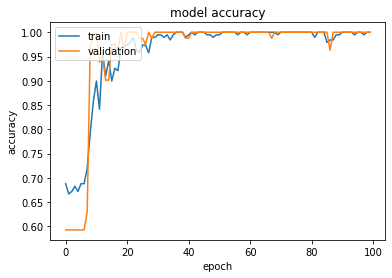

In [75]:
from matplotlib import pyplot as plt
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

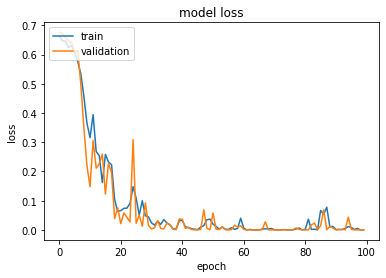

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
# model = tf.keras.models.load_model('TrainedModels/Fire-64x64-color-v7-soft.h5')
model = tf.keras.models.load_model('TrainedModels/take2.h5')

# model.fit_generator(datagen.flow(X, Y, batch_size=32),
#                     epochs=100,
#                   verbose=1)

In [ ]:
plot_model(model, to_file='model_small.svg', show_layer_names=False, show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [ ]:
conda install pydotplus


NotWritableError: The current user does not have write permissions to a required path.
  path: /home/simbox/.conda/pkgs/urls.txt
  uid: 1000
  gid: 1000

If you feel that permissions on this path are set incorrectly, you can manually
change them by executing

  $ sudo chown 1000:1000 /home/simbox/.conda/pkgs/urls.txt

In general, it's not advisable to use 'sudo conda'.



Note: you may need to restart the kernel to use updated packages.
